In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [251]:
tickerSymbol = 'AAPl'   #EMG.L
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d',start='2017-4-1',end='2022-6-1',)
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03 00:00:00-04:00,33.768542,33.864879,33.613456,33.766190,79942800,0.0,0.0
2017-04-04 00:00:00-04:00,33.660447,34.045809,33.641648,34.017612,79565600,0.0,0.0
2017-04-05 00:00:00-04:00,33.888380,34.179752,33.792038,33.841385,110871600,0.0,0.0
2017-04-06 00:00:00-04:00,33.904816,33.958863,33.707436,33.756783,84596000,0.0,0.0
2017-04-07 00:00:00-04:00,33.773240,33.878978,33.665152,33.681599,66688800,0.0,0.0


In [252]:
first_diff = tickerDf.Close.values[1:]-tickerDf.Close.values[:-1]
first_diff = np.concatenate([first_diff,[0]])
tickerDf['FirstDifference'] = first_diff
#tickerDf.Close.pct_change().dropna()

In [253]:
tickerDf[0:20]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference
Date,,,,,,,,
2017-04-03 00:00:00-04:00,33.768542,33.864879,33.613456,33.766190,79942800,0.0,0.0,0.251423
2017-04-04 00:00:00-04:00,33.660447,34.045809,33.641648,34.017612,79565600,0.0,0.0,-0.176228
2017-04-05 00:00:00-04:00,33.888380,34.179752,33.792038,33.841385,110871600,0.0,0.0,-0.084602
2017-04-06 00:00:00-04:00,33.904816,33.958863,33.707436,33.756783,84596000,0.0,0.0,-0.075184
2017-04-07 00:00:00-04:00,33.773240,33.878978,33.665152,33.681599,66688800,0.0,0.0,-0.039955
2017-04-10 00:00:00-04:00,33.742685,33.808479,33.578199,33.641644,75733600,0.0,0.0,-0.361858
2017-04-11 00:00:00-04:00,33.587604,33.683946,32.910870,33.279785,121517600,0.0,0.0,0.039944
2017-04-12 00:00:00-04:00,33.272734,33.401969,33.134095,33.319729,81400000,0.0,0.0,-0.176239
2017-04-13 00:00:00-04:00,33.345570,33.456010,33.143490,33.143490,71291600,0.0,0.0,0.183292


In [254]:
tickerDfResample = pd.DataFrame(tickerDf.resample('W-Mon').sum())
tickerDfResample

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference
Date,,,,,,,,
2017-04-03 00:00:00-04:00,33.768542,33.864879,33.613456,33.766190,79942800,0.00,0.0,0.251423
2017-04-10 00:00:00-04:00,168.969567,169.871881,168.384473,168.939022,417455600,0.00,0.0,-0.737827
2017-04-17 00:00:00-04:00,133.450448,133.880456,132.289657,133.069786,340537600,0.00,0.0,-0.101032
2017-04-24 00:00:00-04:00,166.939390,167.677211,166.304950,166.887691,359202800,0.00,0.0,0.782475
2017-05-01 00:00:00-04:00,169.533528,170.395893,168.899091,169.707405,430489200,0.00,0.0,0.700226
...,...,...,...,...,...,...,...,...
2022-05-09 00:00:00-04:00,789.495213,803.368834,773.151419,788.497391,575450800,0.23,0.0,-4.721634
2022-05-16 00:00:00-04:00,739.673859,751.717127,722.625838,733.981201,641293200,0.00,0.0,-5.253952
2022-05-23 00:00:00-04:00,710.303407,720.552145,691.331263,705.956680,579327200,0.00,0.0,-8.853012


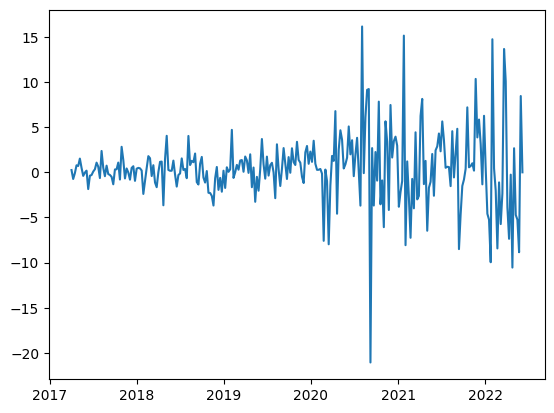

In [255]:
plt.plot(tickerDfResample['FirstDifference'])



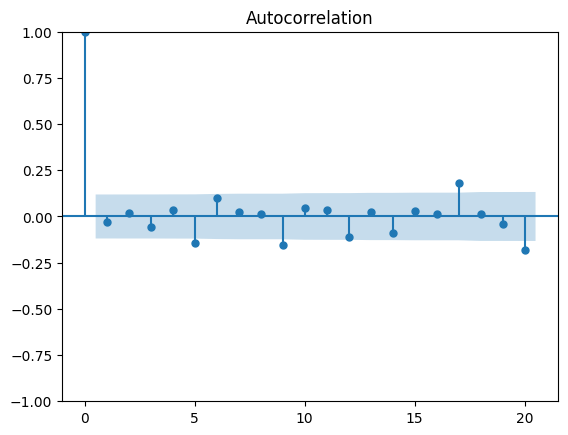

In [256]:
acf_plot = plot_acf(tickerDfResample.FirstDifference, lags=20)

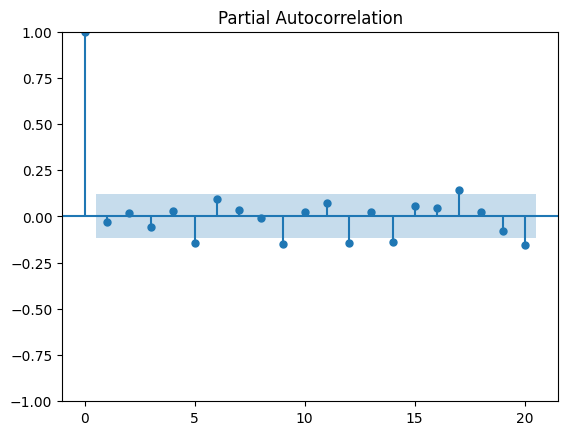

In [258]:
pacf_plot = plot_pacf(tickerDfResample.FirstDifference,lags=20)



In [260]:
tickerDfResample[-20:]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference
Date,,,,,,,,
2022-01-24 00:00:00-05:00,828.123727,837.071794,811.818366,819.811966,562335700,0.00,0.0,-9.962173
2022-01-31 00:00:00-05:00,816.063743,831.514066,800.782437,819.046432,641505600,0.00,0.0,14.744431
2022-02-07 00:00:00-05:00,863.209076,870.401829,854.863803,862.830658,420262900,0.22,0.0,0.440186
2022-02-14 00:00:00-05:00,857.739612,866.221246,848.640760,856.873535,421836300,0.00,0.0,-2.030823
2022-02-21 00:00:00-05:00,680.591025,685.638169,671.920245,678.450699,276066800,0.00,0.0,-8.431839
2022-02-28 00:00:00-05:00,806.352075,822.508992,793.609718,813.420135,509350300,0.00,0.0,-1.114960
2022-03-07 00:00:00-05:00,821.692699,829.686549,807.954846,814.773987,420033600,0.00,0.0,-5.734055
2022-03-14 00:00:00-04:00,787.318209,796.476788,772.296186,780.728027,533647400,0.00,0.0,-2.339417
2022-03-21 00:00:00-04:00,787.019541,803.763814,781.703609,801.036133,490203000,0.00,0.0,13.668182


In [276]:
trainData = tickerDfResample['Close'][:'2022-03-28 00:00:00-04:00']
testData = pd.DataFrame(tickerDfResample['Close']['2022-04-04 00:00:00-04:00':])

In [277]:
trainData,testData

(Date
 2017-04-03 00:00:00-04:00     33.766190
 2017-04-10 00:00:00-04:00    168.939022
 2017-04-17 00:00:00-04:00    133.069786
 2017-04-24 00:00:00-04:00    166.887691
 2017-05-01 00:00:00-04:00    169.707405
                                 ...    
 2022-02-28 00:00:00-05:00    813.420135
 2022-03-07 00:00:00-05:00    814.773987
 2022-03-14 00:00:00-04:00    780.728027
 2022-03-21 00:00:00-04:00    801.036133
 2022-03-28 00:00:00-04:00    859.531555
 Freq: W-MON, Name: Close, Length: 261, dtype: float64,
                                 Close
 Date                                 
 2022-04-04 00:00:00-04:00  880.108429
 2022-04-11 00:00:00-04:00  851.020004
 2022-04-18 00:00:00-04:00  665.409714
 2022-04-25 00:00:00-04:00  822.001266
 2022-05-02 00:00:00-04:00  789.050385
 2022-05-09 00:00:00-04:00  788.497391
 2022-05-16 00:00:00-04:00  733.981201
 2022-05-23 00:00:00-04:00  705.956680
 2022-05-30 00:00:00-04:00  572.553574
 2022-06-06 00:00:00-04:00  148.387390)

In [268]:
model = ARIMA(trainData.values,order=(5,1,5))

In [269]:
modelFit = model.fit()

C:\Users\X99S5\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [271]:
print(modelFit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  261
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1343.125
Date:                Mon, 23 Jan 2023   AIC                           2708.251
Time:                        13:59:43   BIC                           2747.418
Sample:                             0   HQIC                          2723.997
                                - 261                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1503      0.313     -0.480      0.631      -0.764       0.463
ar.L2         -0.4685      0.284     -1.652      0.099      -1.024       0.087
ar.L3         -0.6922      0.281     -2.466      0.0

In [278]:
testData

,Close
Date,
2022-04-04 00:00:00-04:00,880.108429
2022-04-11 00:00:00-04:00,851.020004
2022-04-18 00:00:00-04:00,665.409714
2022-04-25 00:00:00-04:00,822.001266
2022-05-02 00:00:00-04:00,789.050385
2022-05-09 00:00:00-04:00,788.497391
2022-05-16 00:00:00-04:00,733.981201
2022-05-23 00:00:00-04:00,705.956680
2022-05-30 00:00:00-04:00,572.553574


In [281]:
testData['Predictions'] = modelFit.predict(start = 261 ,end =  270) # predcits via index weirdly
#residuals = testData - pred

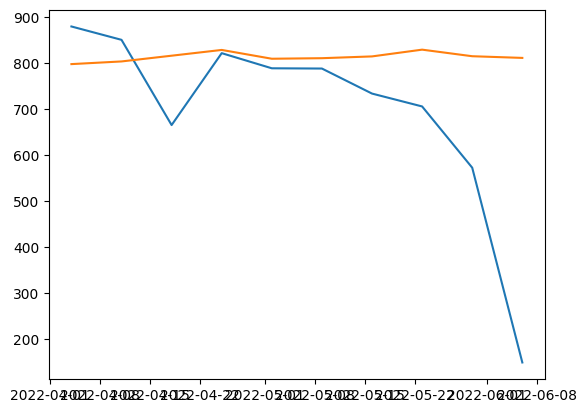

In [283]:
plt.plot(testData['Close'])
plt.plot(testData['Predictions'])